<a href="https://colab.research.google.com/github/0xtaha/image-super-resloution-for-remote-sensing/blob/main/colab_notebooks/Image_Super_Resolution_with_the_SRCNN_(Jupyter_Notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using The Super Resolution Convolutional Neural Network for Image Restoration


Welcome to this tutorial on single-image super-resolution.  The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, **enhance!** 

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras.  This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong, et al. in 2014.  You can read the full paper at https://arxiv.org/abs/1501.00092.

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images.  As a result, we can use it to improve the image quality of low resolution images.  To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.  

Furthermore, we will be using OpenCV, the Open Source Computer Vision Library.  OpenCV was originally developed by Intel and is used for many real-time computer vision applications.  In this particular project, we will be using it to pre and post process our images.  As you will see later, we will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces.  This is necessary because the SRCNN network was trained on the luminance (Y) channel in the YCrCb color space.  

During this project, you will learn how to: 

* use the PSNR, MSE, and SSIM image quality metrics,
* process images using OpenCV,
* convert between the RGB, BGR, and YCrCb color spaces,
* build deep neural networks in Keras,
* deploy and evaluate the SRCNN network

### 1. Importing Packages
Let's dive right in! In this first cell, we will import the libraries and packages we will be using in this project and print their version numbers.  This is an important step to make sure we are all on the same page; furthermore, it will help others reproduce the results we obtain. 

In [ ]:
# check package versions
import sys
import matplotlib
from multiprocessing import Pool

print('Python: {}'.format(sys.version))
print('Matplotlib: {}'.format(matplotlib.__version__))

Python: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Matplotlib: 3.2.2


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import clear_session

from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import glob
import cv2
import pandas as pd
import tensorflow as tf


# python magic function, displays pyplot figures in the notebook
%matplotlib inline

## Downloading the Dataset

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

--2021-02-06 19:08:38--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  35.4MB/s    in 12s     

2021-02-06 19:08:51 (25.5 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [ ]:
!unzip /content/UCMerced_LandUse.zip -d /content/
Land_images = glob.glob('/content/UCMerced_LandUse/Images/**/*.tif') #returns path of images
print(len(Land_images)) #contains 13243 images

Archive:  /content/UCMerced_LandUse.zip
replace /content/UCMerced_LandUse/Images/agricultural/agricultural00.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: /content/UCMerced_LandUse/Images/

### 2. Image Quality Metrics
To start, lets define a couple of functions that we can use to calculate the PSNR, MSE, and SSIM.  The structural similiarity (SSIM) index was imported directly from the scikit-image library; however, we will have to define our own functions for the PSNR and MSE.  Furthermore, we will wrap all three of these metrics into a single function that we can call later.    

In [ ]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

def PSNRLoss(y_true, y_pred):
    return -tf.reduce_mean(tf.image.psnr(y_true, y_pred , max_val=2.0))

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


### 3. Preparing Images

For this project, we will be using the same images that were used in the original SRCNN paper.  We can download these images from http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html.  The .zip file identified as the MATLAB code contains the images we want.  Copy both the Set5 and Set14 datasets into a new folder called 'source'. 

Now that we have some images, we want to produce low resolution versions of these same images.  We can accomplish this by resizing the images, both downwards and upwards, using OpeCV. There are several interpolation methods that can be used to resize images; however, we will be using bilinear interpolation.  

Once we produce these low resolution images, we can save them in a new folder.

In [ ]:
# prepare degraded images by introducing quality distortions via resizing

from tqdm import tqdm
progress = tqdm(total= len(Land_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(256,256,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, Land_images)


 10%|█         | 213/2100 [00:05<01:21, 23.15it/s]

In [ ]:
def get_low_res(img , factor):
  # find old and new image dimensions
  h, w, _ = img.shape
  new_height = int(h / factor)
  new_width = int(w / factor)
          
  # resize the image - down
  img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
          
  # resize the image - up
  low_img_resloution = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
  return low_img_resloution


In [ ]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2 , train_size = 0.8)

In [ ]:
all_images.shape

(2100, 256, 256, 3)

In [ ]:
# get low resloution images for training
train_x_low = []

for i in range(train_x.shape[0]):
  temp = get_low_res(train_x[i,:,:,:] , 3)
  train_x_low.append(temp)
train_x_low = np.array(train_x_low)

val_x_low = []

for i in range(val_x.shape[0]):
  temp = get_low_res(val_x[i,:,:,:] , 3)
  val_x_low.append(temp)
val_x_low = np.array(val_x_low)



In [ ]:
del all_images
del img_array

In [ ]:
import gc
gc.collect()

256

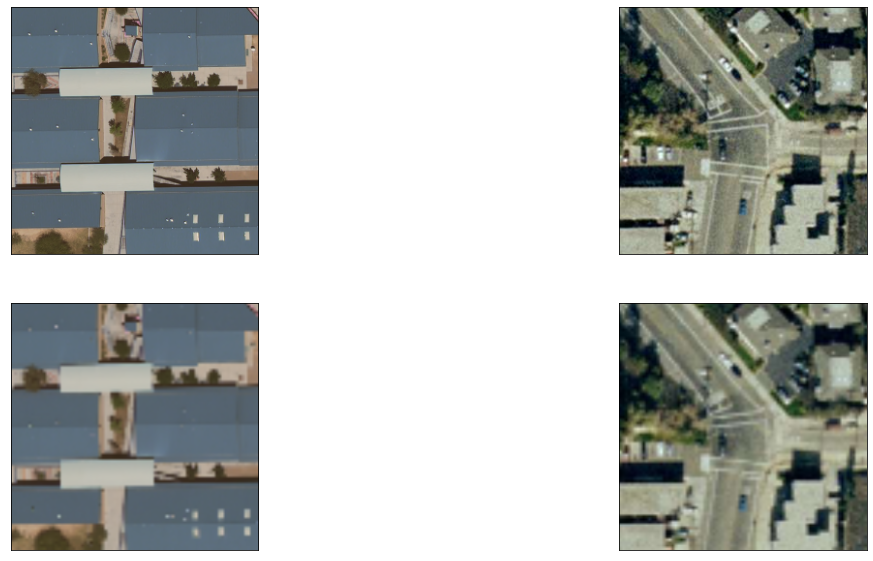

In [ ]:
n = 2
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(train_x[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(train_x_low[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### 3. Testing Low Resolution Images

To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded, lets calculate the PSNR, MSE, and SSIM between our reference images and the degraded images that we just prepared.  

In [ ]:
# test the generated images using the image quality metrics

for i in range(val_x.shape[0]):
    
    # open target and reference images
    target = val_x_low[i,:,:,:]
    ref = val_x[i,:,:,:]
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(i, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


0
PSNR: 69.62749087187154
MSE: 0.02125458004236025
SSIM: 0.7432889215753075

1
PSNR: 71.0093946525283
MSE: 0.015461874729309065
SSIM: 0.8407529150770197

2
PSNR: 74.43586724900351
MSE: 0.00702449148977853
SSIM: 0.8687959885212907

3
PSNR: 73.4056295540274
MSE: 0.008905097117843427
SSIM: 0.7716399014495656

4
PSNR: 74.08852250562963
MSE: 0.007609381619417339
SSIM: 0.8140940045882802

5
PSNR: 70.96700627031203
MSE: 0.015613525919712762
SSIM: 0.7762748967583777

6
PSNR: 73.81026927069964
MSE: 0.008112873205308974
SSIM: 0.8409476171966501

7
PSNR: 87.0306741948987
MSE: 0.00038648638209879327
SSIM: 0.9801971858303516

8
PSNR: 81.99468197766578
MSE: 0.0012323481510287783
SSIM: 0.9316242497982571

9
PSNR: 72.45253504264959
MSE: 0.011090423010848316
SSIM: 0.8090861894777062

10
PSNR: 72.62649151656721
MSE: 0.010654975708395353
SSIM: 0.8315285862555956

11
PSNR: 72.9272799615487
MSE: 0.009941996809494145
SSIM: 0.8484001957694755

12
PSNR: 76.62016391548887
MSE: 0.004248007003135237
SSIM: 0.8673

## Combining Loss Functions

Let's try using a loss that doesn't just tell us the pixel-wise difference in resolution, but that also if there's an improvement, for example, in high frequency details.

### MSE and HFENN

We can do a weight sum of both losses like:

$MSE + weight * HFENN$

We could choose $weight = 10$ and see what happens. 


The HFENN (High Frequency Error Norm Normalized) metric gives  a  measure  of how high-frequency details differ between two images.

This means that we can guess if an image has more or less high frequency details (which are fine details that you need to zoom in to see and that are not blurry) compared to another image.

When the output value is 0 the images are identical. The greater the value, the more of a perceptual difference in both images there is.

In [ ]:
import scipy.ndimage as nd
import scipy.ndimage.filters as filters
from keras import losses
import tensorflow as tf

def hfenn_loss(ori, res):
    '''
    HFENN-based loss
    ori, res - batched images with 3 channels
    See metrics.hfenn
    '''
    fnorm = 0.325 # norm of l_o_g operator, estimated numerically
    sigma = 1.5 # parameter from HFEN metric
    truncate = 4 # default parameter from filters.gaussian_laplace
    wradius = int(truncate * sigma + 0.5)
    eye = np.zeros((2*wradius+1, 2*wradius+1), dtype=np.float32)
    eye[wradius, wradius] = 1.
    ker_mat = filters.gaussian_laplace(eye, sigma)
    with tf.name_scope('hfenn_loss'):
        chan = 3
        ker = tf.constant(np.tile(ker_mat[:, :, None, None], (1, 1, chan, 1)))
        filtered = tf.nn.depthwise_conv2d(ori - res, ker, [1, 1, 1, 1], 'VALID')
        loss = tf.reduce_mean(tf.square(filtered))
        loss = loss / (fnorm**2)
    return loss
  

def ae_loss(input_img, decoder):
    mse = losses.mean_squared_error(input_img, decoder) # MSE
    weight = 10.0 # weight
    return mse + weight * hfenn_loss(input_img, decoder) # MSE + weight * HFENN


### 4. Building the SRCNN Model

Now that we have our low resolution images and all three image quality metrics functioning properly, we can start building the SRCNN. In Keras, it's as simple as adding layers one after the other.  The achitecture and hyper parameters of the SRCNN network can be obtained from the publication referenced above.  

In [ ]:
clear_session()

# define the SRCNN model
# define model type
Input_img = Input(shape=(256, 256, 3))  
    
# add model layers
l1 = Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True)(Input_img)
l2 = Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True)(l1)
result = Conv2D(filters=3, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True)(l2)

adam = Adam(lr=0.0003)

SRCNN = Model(Input_img, result )

# compile model
SRCNN.compile(optimizer='adam', loss='mse', metrics=[ssim,psnr,'accuracy'])    

## Training the model

In [ ]:
SRCNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 128)     31232     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 3)       4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
history = SRCNN.fit(train_x_low,train_x,
            epochs=30,
            validation_data=(val_x_low, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  warn('DEPRECATED: skimage.measure.compare_ssim has been moved to '


ValueError: ignored

### 5. Deploying the SRCNN

Now that we have defined our model, we can use it for single-image super-resolution.  However, before we do this, we will need to define a couple of image processing functions.  Furthermore, it will be necessary to preprocess the images extensively before using them as inputs to the network.  This processing will include cropping and color space conversions. 

Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN.  These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras

Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side.  

In [ ]:
# define main prediction function

    
# load the srcnn model with weights
#SRCNN.load_weights('/content/superResolution_checkpoint3.h5')
    
predictions = SRCNN.predict(val_x_low)

In [ ]:
SRCNN.evaluate(x = val_x_low , y = val_x )

14/14 [==============================] - 2s 118ms/step - loss: 0.0030 - accuracy: 0.8754


[0.0029628367628902197, 0.875403642654419]

In [ ]:
def predict(image_index):
  # image quality calculations
  ref = val_x[image_index]
  degraded = val_x_low[image_index]
  output = predictions[image_index]
  scores = []
  scores.append(compare_images(val_x_low[i], val_x[i]))
  scores.append(compare_images(predictions[i], val_x[i]))
    
  # return images and scores
  return ref, degraded, output, scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Degraded Image: 
PSNR: 80.63554198184045
MSE: 0.001685184350557634
SSIM: 0.9350266936135793

Reconstructed Image: 
PSNR: 80.64208312640355
MSE: 0.0016826481135381246
SSIM: 0.9362654387124009



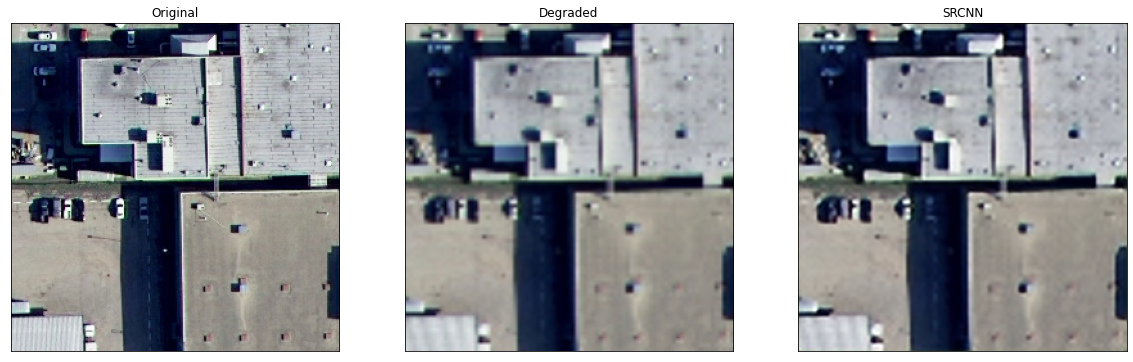

In [ ]:
ref, degraded, output, scores = predict(20)

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(ref)
axs[0].set_title('Original')
axs[1].imshow(degraded)
axs[1].set_title('Degraded')
axs[2].imshow(output)
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)

In [ ]:
ssim1 = list(map(SSIM,val_x,predictions))
ssim2 = list(map(SSIM,val_x,val_x_low))

mse1 = list(map(mse , val_x, predictions))
mse2 = list(map(mse, val_x, val_x_low))

Psnr1 = list(map(Psnr , val_x , predictions))
Psnr2 = list(map(Psnr , val_x , val_x_low))

In [ ]:
metrics = pd.DataFrame(list(zip(ssim1, ssim2, Psnr1, Psnr2, mse1, mse2)), 
               columns =['SSIM after', 'SSIM before' ,'PSNR after', 'PSNR before', 'mean squere error after', 'mean squere error before' ]) 

In [ ]:
metrics.head()

,SSIM after,SSIM before,PSNR after,PSNR before,mean squere error after,mean squere error before
0,0.906261,0.893654,26.901560,26.182352,0.006123,0.007226
1,0.861692,0.851327,25.789639,25.498747,0.007910,0.008458
2,0.924327,0.919145,32.353951,31.544182,0.001745,0.002102
3,0.837796,0.820558,24.610701,24.036274,0.010377,0.011844
4,0.851147,0.832587,26.571703,25.092773,0.006606,0.009286


In [ ]:
metrics.mean(axis = 0)

SSIM after                   0.860951
SSIM before                  0.848333
PSNR after                  27.382011
PSNR before                 26.843934
mean squere error after      0.008889
mean squere error before     0.009832
dtype: float64